In [1023]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree






# 1. Data Gathering

In [970]:
data = pd.read_csv('BigCitiesHealth.csv')

# 2. Data PreProcessing
Handling missing values, removing duplicates, normalizing and scaling values, encoding categorical variables. 

### Dropping not relevant features
Can be because of too many missing values or because it is the same as another one

In [785]:
data = data.drop(['value_90_ci_low', 'value_90_ci_high', 'geo_label_proxy_footnote', 'date_label_proxy_footnote', 'strata_race_sex_label', 
                  'metric_item_label_subtitle', 'metric_source_desc_label_url_fn', 'geo_label_city', 'geo_label_state'], axis=1)

Drop the rows where value flag is no, because there are too many missing values in general and therefore a low validity.

In [786]:
data = data.drop(data[data['value_ci_flag_yesno'].str.contains('no')].index)
data = data.dropna(subset=['geo_strata_region'])
data = data.dropna(subset=['value_95_ci_low'])

len(data)


93092

In [787]:
data.isnull().sum()

metric_item_label              0
metric_cat_label               0
metric_subcat_label            0
metric_cat_item_yaxis_label    0
metric_source_desc_label_fn    0
geo_label_citystate            0
geo_fips_code                  0
value                          0
date_label                     0
geo_label_proxy_or_real        0
geo_fips_desc                  0
date_label_proxy_or_real       0
value_ci_flag_yesno            0
value_95_ci_low                0
value_95_ci_high               0
geo_strata_region              0
geo_strata_poverty             0
geo_strata_Population          0
geo_strata_PopDensity          0
geo_strata_Segregation         0
strata_race_label              0
strata_sex_label               0
dtype: int64

To get the difference between the values and get a better column to represent it

In [788]:
data['ci_magnitude'] = data['value_95_ci_high'] - data['value_95_ci_low']
data = data.drop(['value_95_ci_high', 'value_95_ci_low'], axis = 1)

,metric_item_label,metric_cat_label,metric_subcat_label,metric_cat_item_yaxis_label,metric_source_desc_label_fn,geo_label_citystate,geo_fips_code,value,date_label,geo_label_proxy_or_real,...,date_label_proxy_or_real,value_ci_flag_yesno,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,strata_race_label,strata_sex_label,ci_magnitude
0,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Per 100,000","National Vital Statistics System (NVSS), Cente...","Dallas, TX",4819000.0,271.876868,2020,real,...,real,yes,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),Hispanic,Male,67.060204
1,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Per 100,000","National Vital Statistics System (NVSS), Cente...","Fort Worth, TX",4827000.0,333.954685,2020,real,...,real,yes,South,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),Asian/PI,Male,467.975141
2,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Per 100,000","National Vital Statistics System (NVSS), Cente...","San Antonio, TX",4865000.0,85.391551,2020,real,...,real,yes,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),White,Male,24.711527
3,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Per 100,000","National Vital Statistics System (NVSS), Cente...","Chicago, IL",1714000.0,354.585206,2020,real,...,real,yes,Midwest,Less poor cities (<20% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),Hispanic,Male,53.188526
4,COVID-19 Deaths,Infectious Diseases,Respiratory Infection,"Per 100,000","National Vital Statistics System (NVSS), Cente...","Kansas City, MO",2938000.0,187.017704,2020,real,...,real,yes,Midwest,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),Hispanic,Male,212.042612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148287,Premature Death,Life Expectancy and Deaths,Deaths,"Years per 100,000 population aged <75","National Vital Statistics System (NVSS), Cente...","New York City, NY",3651000.0,5786.217877,2020,real,...,real,yes,Northeast,Less poor cities (<20% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),Hispanic,Both,235.461164
148288,Premature Death,Life Expectancy and Deaths,Deaths,"Years per 100,000 population aged <75","National Vital Statistics System (NVSS), Cente...","Milwaukee, WI",5553000.0,7087.929743,2020,real,...,real,yes,Midwest,Poorest cities (20%+ poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),Hispanic,Both,1259.165653
148289,Premature Death,Life Expectancy and Deaths,Deaths,"Years per 100,000 population aged <75","National Vital Statistics System (NVSS), Cente...","Houston, TX",4835000.0,4099.348306,2011,real,...,real,yes,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),Asian/PI,Both,752.119207
148290,Premature Death,Life Expectancy and Deaths,Deaths,"Years per 100,000 population aged <75","National Vital Statistics System (NVSS), Cente...","Milwaukee, WI",5553000.0,5706.528569,2014,real,...,real,yes,Midwest,Poorest cities (20%+ poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),Asian/PI,Both,2224.342984


In [1027]:
data['metric_item_label'].unique()

array(['COVID-19 Deaths', 'Diabetes Deaths', 'Deaths from All Causes',
       'Dental Care', 'Prenatal Care', 'Teen Asthma', 'All Cancer Deaths',
       'Breast Cancer Deaths', 'Lung Cancer Deaths',
       'Cardiovascular Disease Deaths', 'Heart Disease Deaths',
       'High Blood Pressure', 'Diabetes', 'Adult Obesity', 'Teen Obesity',
       'Adult Physical Inactivity', 'Teen Physical Activity Levels',
       'Teen Physical Inactivity', 'Teen Physical Education',
       'Teen Computer Time', 'Teen TV Time', 'Teen Soda',
       'Teen Breakfast', 'Pneumonia or Influenza Deaths',
       'HIV-Related Deaths', 'Maternal Deaths', 'Infant Deaths',
       'Low Birthweight', 'Teen Births', 'Teen Birth Control',
       'Opioid Overdose Deaths', 'Adult Binge Drinking',
       'Drug Overdose Deaths', 'Adult Smoking', 'Teen Smoking',
       'Teen Alcohol', 'Teen Marijuana', 'Adult Mental Distress',
       'Suicide', 'Teen Mental Distress', 'Teen Suicidal Ideation',
       'Electronic Bullying', 'S

In [1028]:
data['metric_cat_label'].unique()

array(['Infectious Diseases', 'Chronic Health Conditions',
       'Life Expectancy and Deaths', 'Access to Health Services',
       'Maternal and Child Health', 'Mental Health and Substance Use',
       'Violence and Injury'], dtype=object)

In [1029]:
data[data['metric_item_label'].str.contains('Dental Care')]

,metric_item_label,metric_cat_label,metric_subcat_label,metric_cat_item_yaxis_label,metric_source_desc_label_fn,geo_label_citystate,geo_fips_code,value,date_label,geo_label_proxy_or_real,...,date_label_proxy_or_real,value_ci_flag_yesno,geo_strata_region,geo_strata_poverty,geo_strata_Population,geo_strata_PopDensity,geo_strata_Segregation,strata_race_label,strata_sex_label,ci_magnitude
15658,Dental Care,Access to Health Services,Oral Health,Percent,Centers for Disease Control and Prevention's P...,"Houston, TX",4835000.0,53.3,2012,real,...,proxy,yes,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),All,Both,0.4
15659,Dental Care,Access to Health Services,Oral Health,Percent,Centers for Disease Control and Prevention's P...,"Seattle, WA",5363000.0,73.5,2020,real,...,proxy,yes,West,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),All,Both,0.6
15660,Dental Care,Access to Health Services,Oral Health,Percent,Centers for Disease Control and Prevention's P...,"Fort Worth, TX",4827000.0,55.0,2013,real,...,proxy,yes,South,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),All,Both,0.6
15661,Dental Care,Access to Health Services,Oral Health,Percent,Centers for Disease Control and Prevention's P...,"New York City, NY",3651000.0,61.2,2012,real,...,proxy,yes,Northeast,Less poor cities (<20% poor),Largest (>1.3 million),Highest pop. density (>10k per sq mi),Highly Segregated (50%+),All,Both,0.1
15662,Dental Care,Access to Health Services,Oral Health,Percent,Centers for Disease Control and Prevention's P...,"Charlotte, NC",3712000.0,61.6,2015,real,...,real,yes,South,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),All,Both,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16050,Dental Care,Access to Health Services,Oral Health,Percent,Centers for Disease Control and Prevention's P...,"Seattle, WA",5363000.0,72.6,2010,real,...,proxy,yes,West,Less poor cities (<20% poor),Smaller (<1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),All,Both,0.6
16051,Dental Care,Access to Health Services,Oral Health,Percent,Centers for Disease Control and Prevention's P...,"Dallas, TX",4819000.0,52.8,2012,real,...,proxy,yes,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),All,Both,0.5
16052,Dental Care,Access to Health Services,Oral Health,Percent,Centers for Disease Control and Prevention's P...,"San Antonio, TX",4865000.0,58.8,2012,real,...,proxy,yes,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Less Segregated (<50%),All,Both,0.4
16053,Dental Care,Access to Health Services,Oral Health,Percent,Centers for Disease Control and Prevention's P...,"Houston, TX",4835000.0,53.3,2014,real,...,real,yes,South,Less poor cities (<20% poor),Largest (>1.3 million),Lower pop. density (<10k per sq mi),Highly Segregated (50%+),All,Both,0.4


In [1030]:
data['metric_cat_item_yaxis_label'].unique()

array(['Per 100,000', 'Percent', 'Per 100,000 females', 'Per 1,000',
       'Per 1,000 females aged 15-19', 'Incidents per 100,000'],
      dtype=object)

### Normalization of numerical values and encoding for categorical features
First we need to find which colums have which property (numerical/categorical)

In [789]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93092 entries, 0 to 148291
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   metric_item_label            93092 non-null  object 
 1   metric_cat_label             93092 non-null  object 
 2   metric_subcat_label          93092 non-null  object 
 3   metric_cat_item_yaxis_label  93092 non-null  object 
 4   metric_source_desc_label_fn  93092 non-null  object 
 5   geo_label_citystate          93092 non-null  object 
 6   geo_fips_code                93092 non-null  float64
 7   value                        93092 non-null  float64
 8   date_label                   93092 non-null  int64  
 9   geo_label_proxy_or_real      93092 non-null  object 
 10  geo_fips_desc                93092 non-null  object 
 11  date_label_proxy_or_real     93092 non-null  object 
 12  value_ci_flag_yesno          93092 non-null  object 
 13  value_95_ci_low

In [779]:
num_features = data.select_dtypes(include=['float64', 'int64']).columns
cat_features = data.select_dtypes(include=['object']).columns

In [780]:
sc = StandardScaler()

data_standardized = sc.fit_transform(data[num_features])
data_standardized = pd.DataFrame(data_standardized, columns=num_features)

In [781]:
data = pd.concat([data, data_standardized])

Delete values high and low and replace by ci_magnitude to have less columns and a better overview

In [714]:
df = pd.get_dummies(data, columns=cat_features, drop_first=True)
df = df.drop(['value_95_ci_low', 'value_95_ci_high'], axis =1)
df

,geo_fips_code,value,date_label,ci_magnitude,metric_item_label_Adult Mental Distress,metric_item_label_Adult Obesity,metric_item_label_Adult Physical Inactivity,metric_item_label_Adult Smoking,metric_item_label_All Cancer Deaths,metric_item_label_Breast Cancer Deaths,...,geo_strata_poverty_Poorest cities (20%+ poor),geo_strata_Population_Smaller (<1.3 million),geo_strata_PopDensity_Lower pop. density (<10k per sq mi),geo_strata_Segregation_Less Segregated (<50%),strata_race_label_Asian/PI,strata_race_label_Black,strata_race_label_Hispanic,strata_race_label_White,strata_sex_label_Female,strata_sex_label_Male
0,4.819000e+06,271.876868,2020.000000,67.060204,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,4.827000e+06,333.954685,2020.000000,467.975141,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,1
2,4.865000e+06,85.391551,2020.000000,24.711527,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,1
3,1.714000e+06,354.585206,2020.000000,53.188526,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,2.938000e+06,187.017704,2020.000000,212.042612,0,0,0,0,0,0,...,0,1,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93087,4.586630e-01,2.788739,1.573515,0.299152,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93088,1.575595e+00,3.477965,1.573515,2.563196,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93089,1.153956e+00,1.895581,-1.306574,1.441803,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93090,1.575595e+00,2.746545,-0.346545,4.697801,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [715]:
df = pd.DataFrame(df)

Only missing values in the numerical features. We need to find out if it is better to implement values or to delete rows

In [716]:

df.isnull().sum()

geo_fips_code                              0
value                                      0
date_label                                 0
ci_magnitude                               0
metric_item_label_Adult Mental Distress    0
                                          ..
strata_race_label_Black                    0
strata_race_label_Hispanic                 0
strata_race_label_White                    0
strata_sex_label_Female                    0
strata_sex_label_Male                      0
Length: 131, dtype: int64

In [717]:
len(df)

186184

Now there are no more missing values. We went from 148292 to 93092 in data length. 

df is our modified dataframe!

In [718]:
df = df.astype(float)

In [719]:
df.dtypes

geo_fips_code                              float64
value                                      float64
date_label                                 float64
ci_magnitude                               float64
metric_item_label_Adult Mental Distress    float64
                                            ...   
strata_race_label_Black                    float64
strata_race_label_Hispanic                 float64
strata_race_label_White                    float64
strata_sex_label_Female                    float64
strata_sex_label_Male                      float64
Length: 131, dtype: object

# 3. Exploratory Data Analysis
Goal is to use statistical methods to visualise and find relationships between variable. To find correlations, outliers, patterns etc.

Get an insight about the value column. It gives us an estimate about sex/grade and ethnicity on a 95 confidence level. 

By adding a column called ci_uncertainty, the variability of each metric can be assessed.

Text(0.5, 1.0, 'Mean Value by Sex')

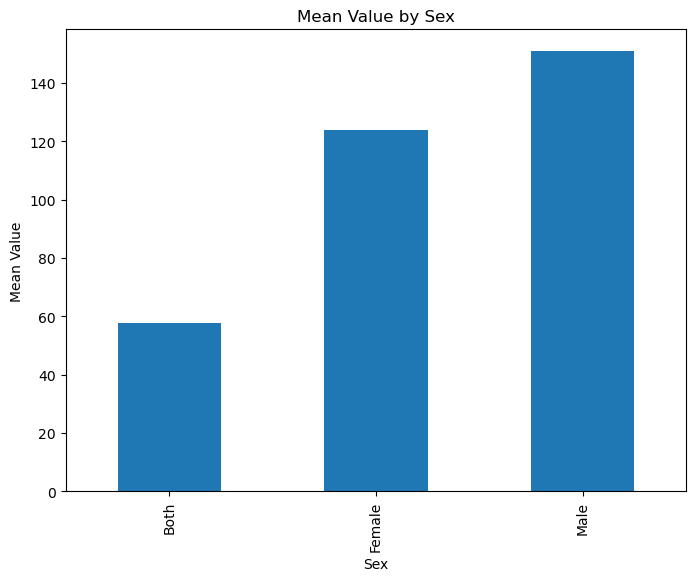

In [720]:
mean_by_sex = data.groupby('strata_sex_label')['ci_magnitude'].mean()


plt.figure(figsize=(8, 6))
mean_by_sex.plot(kind='bar')
plt.xlabel('Sex')
plt.ylabel('Mean Value')
plt.title('Mean Value by Sex')


How this could be interpreted is that there may be specific factors or characteristics associated with males that contribute to higher values or greater variability in the variable.

Text(0.5, 1.0, 'Mean Value by Ethnicity')

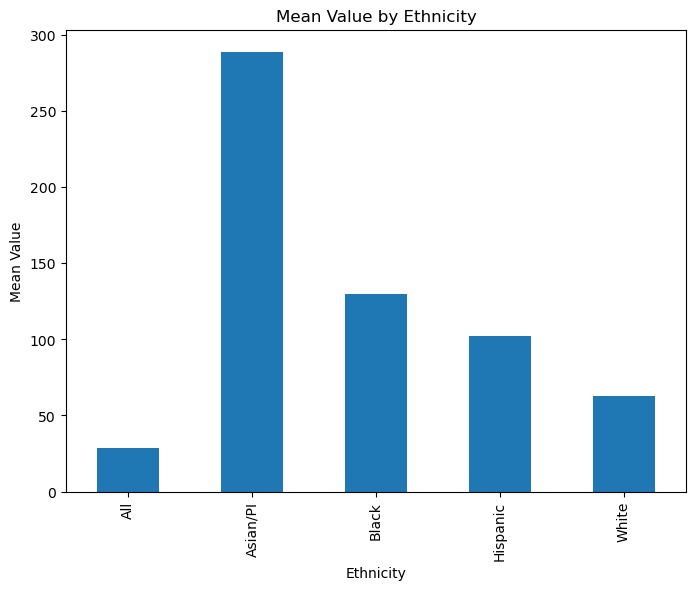

In [721]:
mean_by_race = data.groupby('strata_race_label')['ci_magnitude'].mean()


plt.figure(figsize=(8, 6))
mean_by_race.plot(kind='bar')
plt.xlabel('Ethnicity')
plt.ylabel('Mean Value')
plt.title('Mean Value by Ethnicity')

### Heatmap for categorical correlation

In [722]:
corr_matrix = df.corr()

Text(0.5, 1.0, 'Correlation Heatmap')

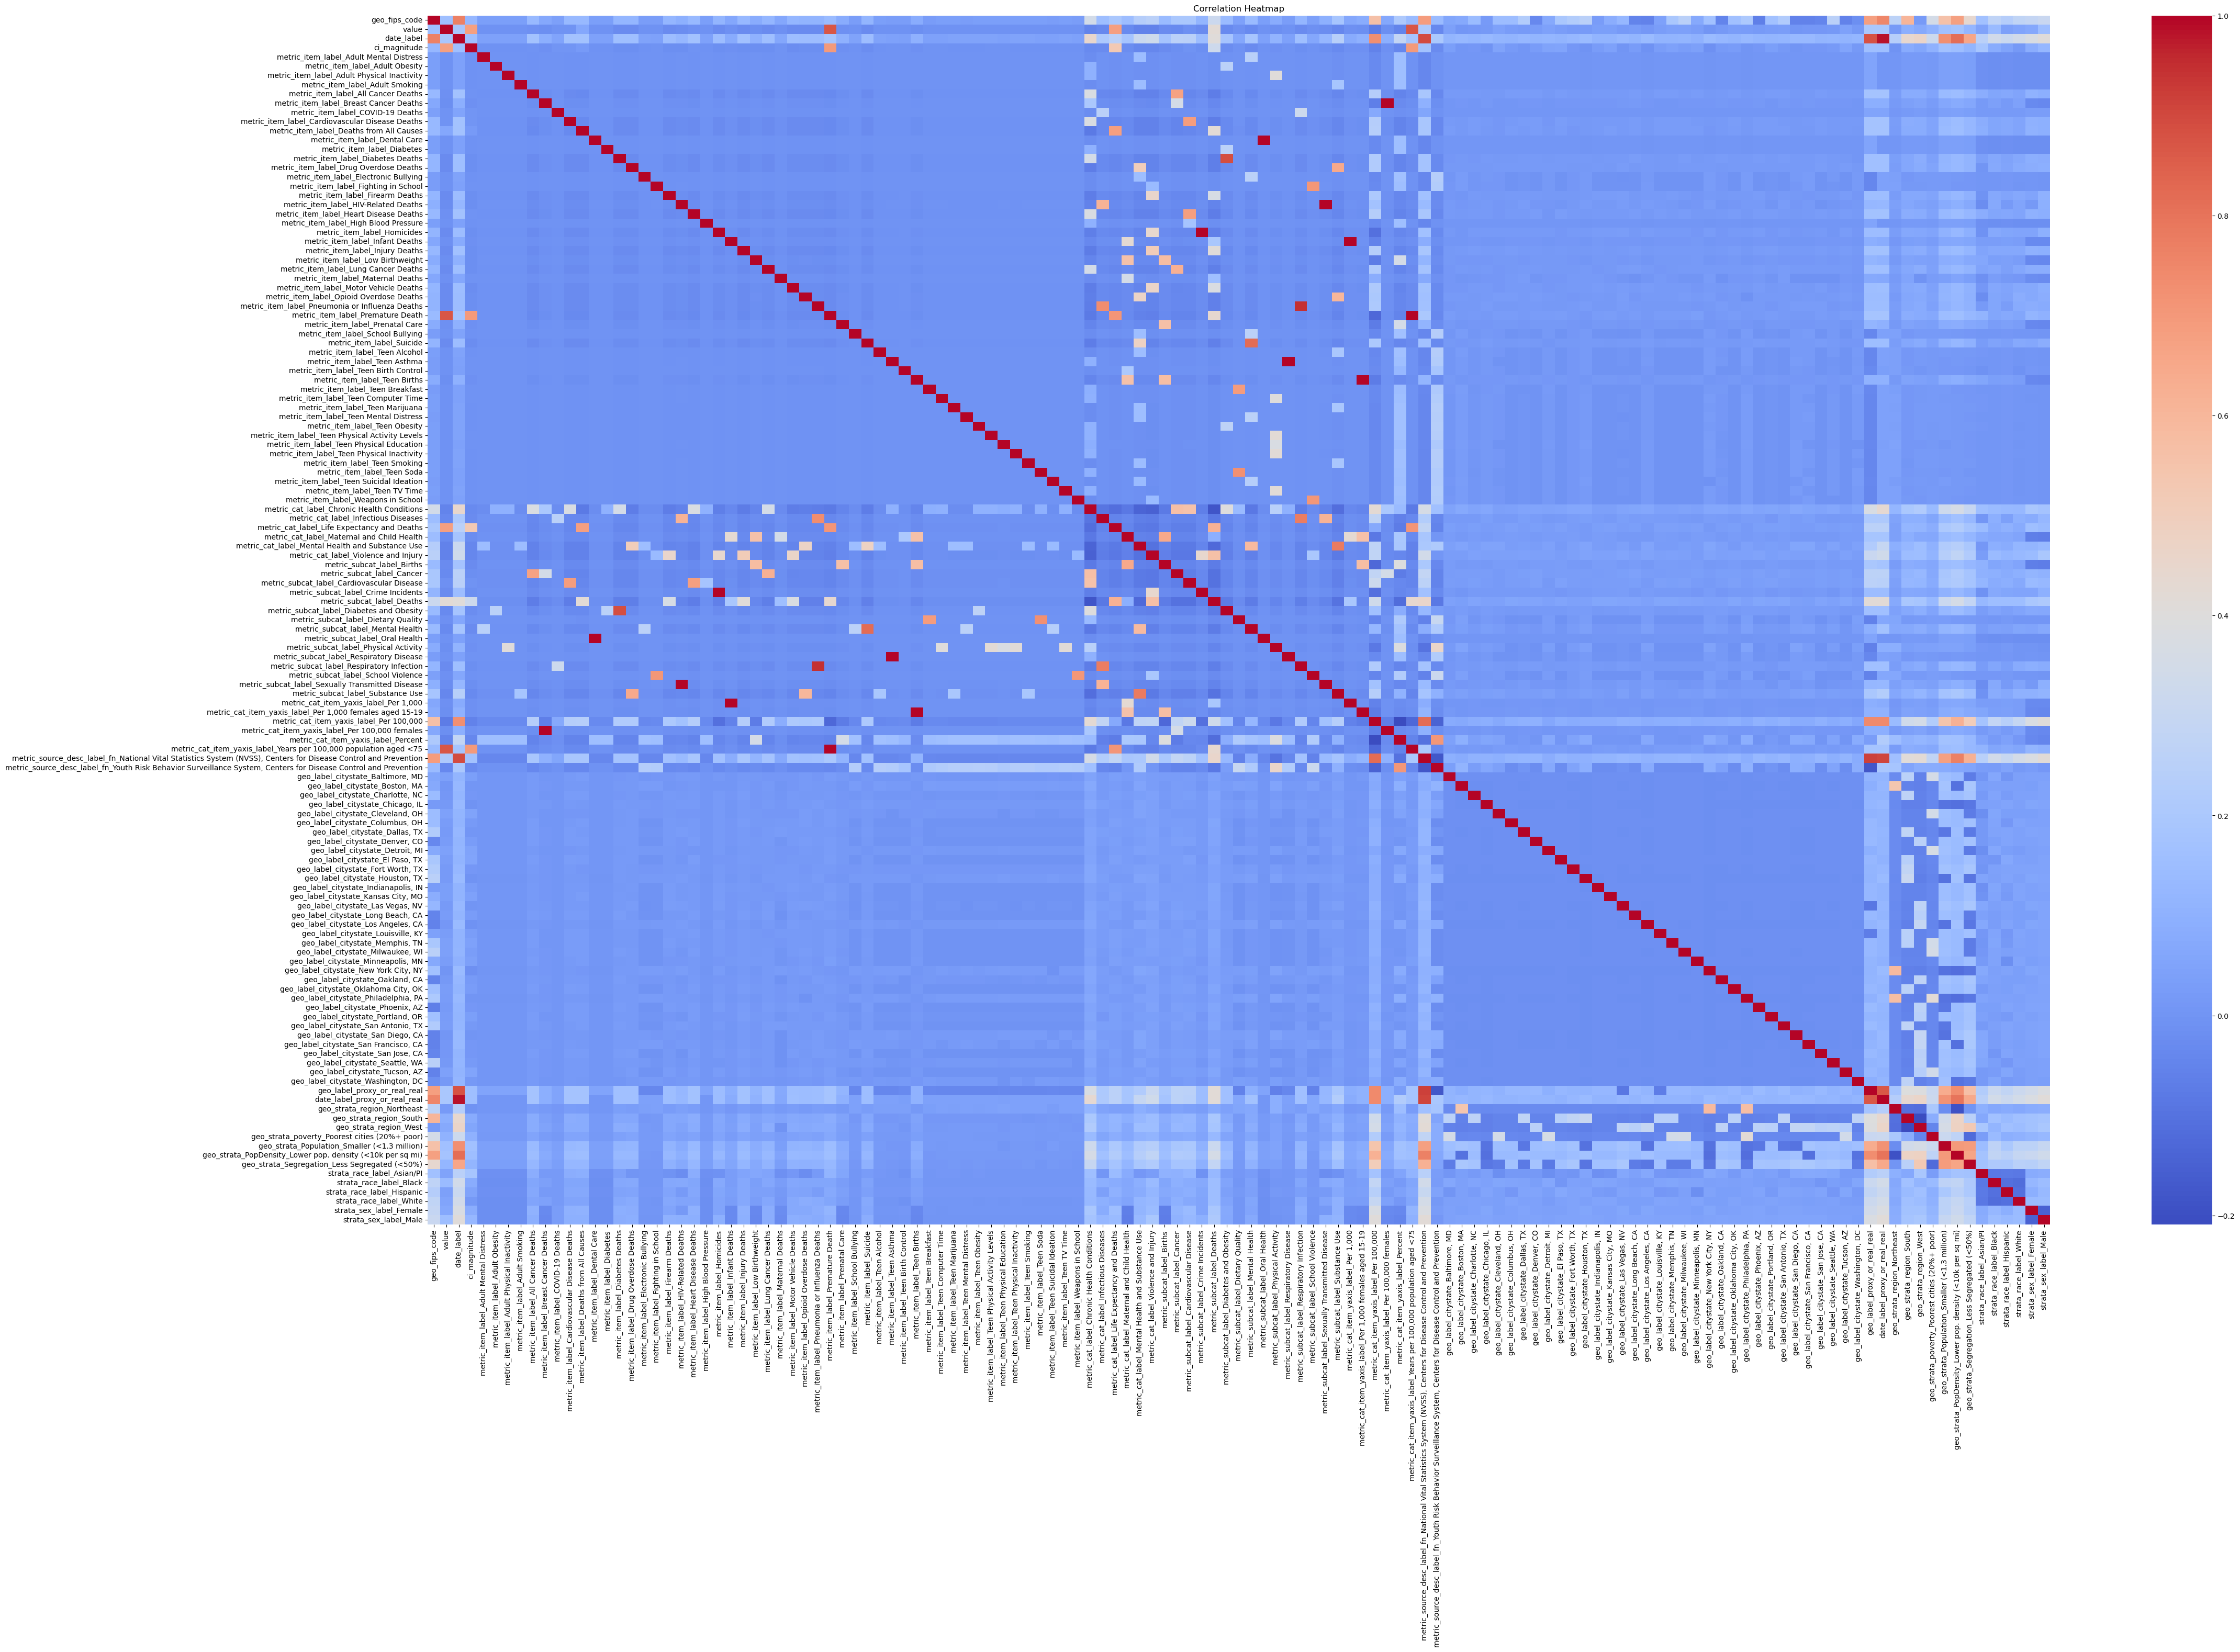

In [723]:
plt.figure(figsize=(50, 30))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', annot_kws={"size": 8})
plt.title('Correlation Heatmap')

In [743]:
# Get the top 20 features with the highest absolute correlation, excluding pairs with same features
top_features = (corr_matrix.abs().unstack()
                .nlargest(40, keep='all')
                .reset_index()
                .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'}))

# Filter out pairs where Feature 1 is the same as Feature 2
top_features = top_features[top_features['Feature 1'] != top_features['Feature 2']]

# Print the top 20 features
top_features

,Feature 1,Feature 2,Correlation
0,metric_item_label_Breast Cancer Deaths,"metric_cat_item_yaxis_label_Per 100,000 females",1.000000
1,metric_item_label_Dental Care,metric_subcat_label_Oral Health,1.000000
2,metric_item_label_HIV-Related Deaths,metric_subcat_label_Sexually Transmitted Disease,1.000000
3,metric_item_label_Homicides,metric_subcat_label_Crime Incidents,1.000000
4,metric_item_label_Infant Deaths,"metric_cat_item_yaxis_label_Per 1,000",1.000000
5,metric_item_label_Premature Death,"metric_cat_item_yaxis_label_Years per 100,000 ...",1.000000
6,metric_item_label_Teen Asthma,metric_subcat_label_Respiratory Disease,1.000000
7,metric_item_label_Teen Births,"metric_cat_item_yaxis_label_Per 1,000 females ...",1.000000
8,metric_subcat_label_Crime Incidents,metric_item_label_Homicides,1.000000
9,metric_subcat_label_Oral Health,metric_item_label_Dental Care,1.000000


### Pearson for numerical only

<AxesSubplot:>

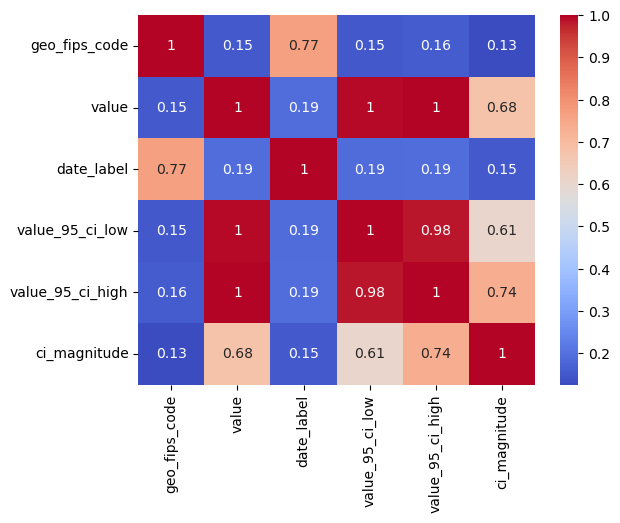

In [ ]:
corr_matrix_pearson = df[num_features].corr()
sns.heatmap(corr_matrix_pearson, annot=True, cmap='coolwarm')


# 4. Feature Selection

In [ ]:
df

,geo_fips_code,value,date_label,value_95_ci_low,value_95_ci_high,metric_item_label_Adult Mental Distress,metric_item_label_Adult Obesity,metric_item_label_Adult Physical Inactivity,metric_item_label_Adult Smoking,metric_item_label_All Cancer Deaths,...,geo_strata_PopDensity_Lower pop. density (<10k per sq mi),geo_strata_Segregation_Less Segregated (<50%),strata_race_label_American Indian/Alaska Native,strata_race_label_Asian,strata_race_label_Asian/PI,strata_race_label_Black,strata_race_label_Hispanic,strata_race_label_White,strata_sex_label_Female,strata_sex_label_Male
0,4.819000e+06,271.876868,2020.000000,240.233095,307.293299,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,4.827000e+06,333.954685,2020.000000,161.906352,629.881493,0,0,0,0,0,...,1,1,0,0,1,0,0,0,0,1
2,4.865000e+06,85.391551,2020.000000,73.839052,98.550579,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,1
3,1.714000e+06,354.585206,2020.000000,328.986597,382.175123,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,2.938000e+06,187.017704,2020.000000,104.928717,316.971329,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148287,4.539220e-01,1.151422,1.533162,2.983356,2.610736,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148288,1.574181e+00,1.453856,1.533162,3.436547,3.498188,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148289,1.151286e+00,0.759500,-1.358382,1.867277,1.911693,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148290,1.574181e+00,1.132907,-0.394534,2.367062,3.058362,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df.drop('metric_subcat_label_Cancer', axis=1)
y = df['metric_subcat_label_Cancer']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


### Random Forest

Text(0.5, 1.0, 'Top 15 features selected by Random Forest')

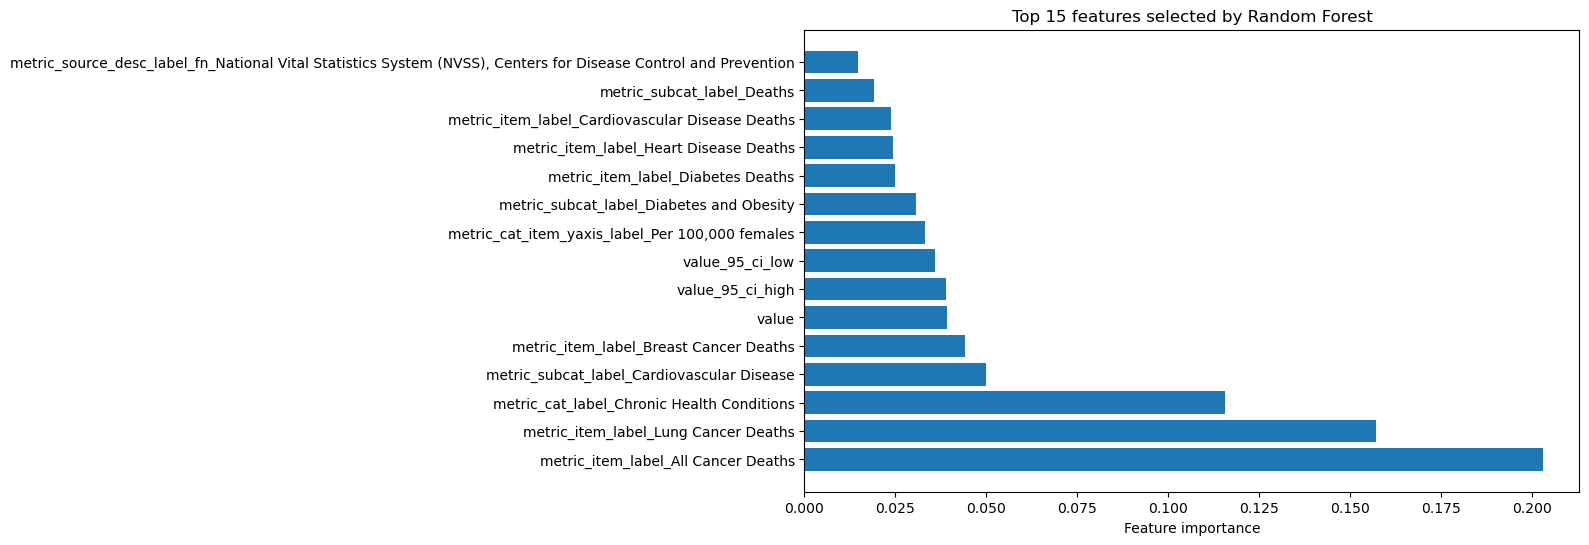

In [ ]:
RF = RandomForestClassifier(random_state=43)
RF.fit(X_train, y_train)

importances_RF = RF.feature_importances_
top_indices_RF = importances_RF.argsort()[::-1][:15]
top_features_RF = X_train.columns[top_indices_RF]

plt.figure(figsize=(10, 6))
plt.barh(top_features_RF, importances_RF[top_indices_RF])
plt.xlabel('Feature importance')
plt.title('Top 15 features selected by Random Forest')

### Correlation Based Feature Selection

In [ ]:
correlation_with_target = corr_matrix['metric_subcat_label_Cancer'].abs().sort_values(ascending=False)
selected_features_corr = correlation_with_target[:15].index.tolist()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

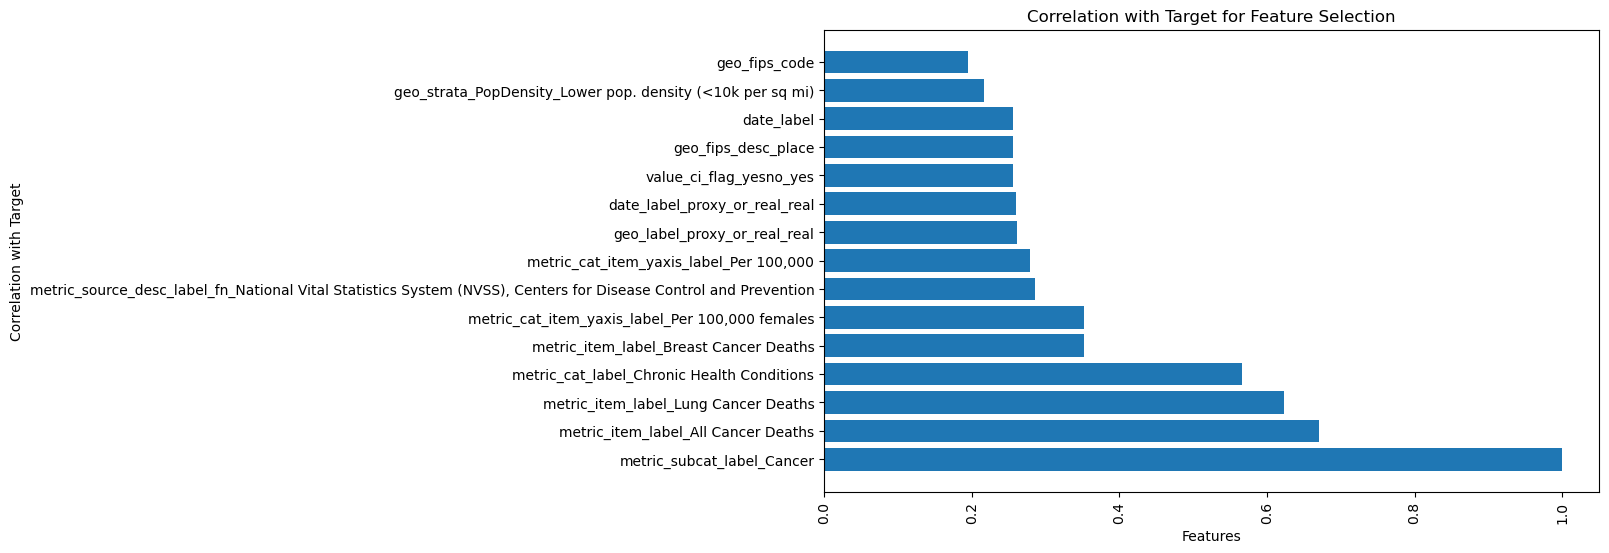

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(selected_features_corr, correlation_with_target[selected_features_corr])
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.title('Correlation with Target for Feature Selection')
plt.xticks(rotation=90)

# 5. Model Selection

# 6. Model Training and Evaluation

# 7. Hyperparameter Tuning

# 8. Model Deployment and Monitoring